In [7]:
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [3]:
d_train = pd.read_csv("../data/text_clean/train.csv")
d_test = pd.read_csv("../data/text_clean/test.csv")

# tokenize
d_train.loc[:, 'title_1_token'] = d_train.title_1_pre.apply(word_tokenize)
d_train.loc[:, 'title_2_token'] = d_train.title_2_pre.apply(word_tokenize)

d_test.loc[:, 'title_1_token'] = d_test.title_1_pre.apply(word_tokenize)
d_test.loc[:, 'title_2_token'] = d_test.title_2_pre.apply(word_tokenize)

In [5]:
d_train.loc[:, 'title_1_len'] = d_train.title_1_token.apply(len)
d_train.loc[:, 'title_2_len'] = d_train.title_2_token.apply(len)

In [9]:
title_len = np.concatenate((d_train.title_1_len.values, d_train.title_2_len.values), axis = 0)

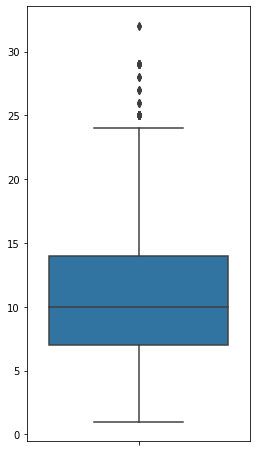

In [14]:
plt.figure(figsize=(4,8))
fig = sns.boxplot(y = title_len)
fig.figure.savefig('../figures/title_length.png')

In [18]:
title_token = list(chain(*d_train.title_1_token.tolist() + d_train.title_2_token.tolist()))

vocab_token = list(set(title_token))

word2idx = dict((w, k) for k, w in enumerate(vocab_token, 2))
idx2word = dict((k, w) for k, w in enumerate(vocab_token, 2))

word2idx['<UNK>'] = 1
idx2word[1] = '<UNK>'
word2idx['<PAD>'] = 0
idx2word[0] = '<PAD>'

In [49]:
class TitleDataset():
    def __init__(self, data, test, word2idx, idx2word):
        train, val = train_test_split(data)
        train.reset_index(drop=True, inplace=True)
        val.reset_index(drop=True, inplace=True)
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataset = {
            'train': (train, train.shape[0]),
            'val': (val, val.shape[0]),
            'test': (test, test.shape[0])
        }
        self.set_split('train')
        
    def set_split(self, split='train'):
        self.data, self.length = self.dataset[split]
    
    def encode(self, text):
        token_ids = []
        for word in text:
            try:
                token_ids.append(self.word2idx[word])
            except:
                token_ids.append(1)
        token_ids = torch.LongTensor(token_ids)
        return token_ids
    
    def decode(self, ids):
        words = []
        for id_ in ids:
            try:
                words.append(self.idx2word[id_])
            except:
                words.append('<UNK>')
                
        return words
    
    def set_fix_length(self, ids):
        length = ids.shape[0]
        zeros = torch.zeros(25, dtype=torch.long)
        
        if length <= 25:
            zeros[:length] = ids
        else:
            zeros = ids[:25]
            
        return zeros
    
    def __getitem__(self, idx):
        t1 = self.data.loc[idx, 'title_1_token']
        t2 = self.data.loc[idx, 'title_2_token']
        label = self.data.loc[idx, 'Label']
        
        t1_encode = self.encode(t1)
        t2_encode = self.encode(t2)
        
        t1_encode = self.set_fix_length(t1_encode)
        t2_encode = self.set_fix_length(t2_encode)
        
        return t1_encode, t2_encode, label
    
    def __len__(self):
        return self.length

In [50]:
dataset = TitleDataset(d_train, d_test, word2idx, idx2word)

In [54]:
num_vocab = len(word2idx)

In [55]:
num_vocab

8476

In [133]:
class TextEncoder(nn.Module):
    def __init__(self, num_vocab, emb_size, hid_size, num_layers):
        super(TextEncoder, self).__init__()
        self.network = nn.Sequential(
            nn.Embedding(num_vocab, emb_size),
            nn.LSTM(emb_size, hid_size, num_layers=num_layers, batch_first=True)
        )
        
    def forward(self, input_):
        out, (h, c) = self.network(input_)
#         out = out.unsqueeze(1)
        
        return out

In [134]:
model = TextEncoder(num_vocab, 512, 256, 1)

In [135]:
num_params = sum(p.numel() for p in model.parameters())

In [136]:
print(f"Trainable parameters {num_params:,}")

Trainable parameters 5,128,192


In [137]:
def pad_text(batch_data):
    t1, t2, label = list(zip(*batch_data))
    t1 = pad_sequence(t1, batch_first=True)
    t2 = pad_sequence(t2, batch_first=True)
    label = torch.LongTensor(label)
    return (t1, t2, label)

In [86]:
dataset.set_split("train")
data_gen = DataLoader(dataset, batch_size = 2)

In [138]:
for title1, title2, label in data_gen:
    break

In [139]:
out1 = model(title1)
out2 = model(title2)

In [140]:
out1.shape

torch.Size([2, 25, 256])

## BERT

In [122]:
from transformers import BertConfig, BertTokenizer, BertModel

In [124]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [127]:
tokens = tokenizer("I will go to school tomorrow")

In [130]:
tokens['input_ids'] = [ 1, 42, 45, 75, 54,  5, 51, 31, 33, 23, 88, 72, 55, 19, 98, 17, 63, 12,
        11, 99, 64, 79, 55, 57, 97]

In [111]:
config = BertConfig(vocab_size=8476, num_attention_heads=2, num_hidden_layers=2, hidden_size=256, max_position_embeddings=512)

In [112]:
config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 8476
}

In [113]:
model = BertModel(config)

In [114]:
num_params = sum(p.numel() for p in model.parameters())

In [115]:
print(f"{num_params:,}")

6,048,512


In [119]:
x = torch.randint(high=100, size=(25,))

In [120]:
x

tensor([ 1, 42, 45, 75, 54,  5, 51, 31, 33, 23, 88, 72, 55, 19, 98, 17, 63, 12,
        11, 99, 64, 79, 55, 57, 97])

In [132]:
model(tokens)

AttributeError: 